In [ ]:
# Install cell, Install if needed

#pip install sklearn
#pip install Keras-Preprocessing

# Resources


ResNet Resource: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

Knowledge Distillation: https://medium.com/analytics-vidhya/knowledge-distillation-in-a-deep-neural-network-c9dd59aff89b

Knowledge Distiller Code: https://keras.io/examples/vision/knowledge_distillation/

F1 Score and AUC Score average selection: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
                                          Since the dataset is binary, the average can be binary in this project

Resnet Model:https://www.kaggle.com/code/iabhishekmaurya/transfer-learning-resnet50v2

Mobile Model: https://www.kaggle.com/code/xhlulu/training-mobilenet-v2-in-4-min/script


In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [2]:
#import block

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
from keras_flops import get_flops
import pandas as pd

import tensorflow.keras as K

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image
from skimage import io

from keras.models import Model
import keras
tf.enable_v2_behavior()

In [3]:
#Variable block
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 25
LEARNING_RATE_TEACHER = 0.0001
LEARNING_RATE_STUDENT_KD = 0.001
LEARNING_RATE_STUDENT_SC = 0.001

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#GPU Memory Reset
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [6]:
#run when job fail happens
reset_keras()

0


# Load Data

In [7]:
#load data use panda

#read annotation file
annotations = pd.read_csv("./annotations.csv", skiprows = 1,
                         names = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)","Partition"])
annotations.head()

#Create dataframe
df = pd.DataFrame(annotations,
                 columns = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)", "Partition"])
df.set_index("Image Name",inplace = True)

df.head()

,Majority Vote Label,Number of Annotations who Selected SSA(Out of 7),Partition
Image Name,,,
MHIST_aaa.png,SSA,6,train
MHIST_aab.png,HP,0,train
MHIST_aac.png,SSA,5,train
MHIST_aae.png,HP,1,train
MHIST_aaf.png,SSA,5,train


# Data Augmentation

In [8]:
#resource: https://www.youtube.com/watch?v=ccdssX4rIh8
SIZE = 224
image_directory = "images/"

datagen = ImageDataGenerator(
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.5,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

all_images = os.listdir(image_directory)

#read test images and process them
test_images = []
test_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'test':
        #load test image and label
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        test_images.append(image_array)
        test_labels.append(df.loc[image_name][0])
            
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print("Test Image Shape: {}".format(test_images.shape))
print("Test Image label: {}".format(test_labels.shape))

#read train images and process them
train_images = []
train_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'train':
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image,'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        train_images.append(image_array)
        train_labels.append(df.loc[image_name][0])
        image_array = image_array.reshape((1,)+image_array.shape)
        iterator = datagen.flow(image_array,batch_size = 1)
        for i in range(1,3):
            batch = iterator.next()
            image = batch[0].astype('uint8')
            train_images.append(image)
            train_labels.append(df.loc[image_name][0])
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print("Train Image Shape: {}".format(train_images.shape))
print("Train Label Shape: {}".format(train_labels.shape))

Test Image Shape: (977, 224, 224, 3)
Test Image label: (977,)
Train Image Shape: (6525, 224, 224, 3)
Train Label Shape: (6525,)


In [9]:
#normalize the test images and train images
train_images_normalized = train_images.astype('float32')/255.0
test_images_normalized = test_images.astype('float32')/255.0

#encode the labels
encoder = LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

In [10]:
print("Unique Value in train labels: {}".format(np.unique(train_labels_encoded)))
print("Unique Value in test labels: {}".format(np.unique(test_labels_encoded)))

print("The number of 1 in train dataset: {}".format(train_labels_encoded.sum()))
print("The number of 0 in train dataset: {}".format(6525-train_labels_encoded.sum()))

print("The number of 1 in test dataset: {}".format(test_labels_encoded.sum()))
print("The number of 0 in test dataset: {}".format(977-test_labels_encoded.sum()))

Unique Value in train labels: [0 1]
Unique Value in test labels: [0 1]
The number of 1 in train dataset: 1890
The number of 0 in train dataset: 4635
The number of 1 in test dataset: 360
The number of 0 in test dataset: 617


# Create Model

In [11]:
#teacher model

def teacher_model():
    res_model = K.applications.resnet_v2.ResNet50V2(include_top = False, weights="imagenet",input_shape=(224,224,3))
    for layer in res_model.layers:
        layer.trainable = False
    x = K.layers.MaxPooling2D(pool_size = (2,2))(res_model.output)
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(100,activation = "relu")(x)
    outputs = K.layers.Dense(2,activation="softmax")(x) 
    teacher = Model(inputs = res_model.input, outputs = outputs)
    return teacher

#student model
def student_model():
    mob_model = K.applications.mobilenet_v2.MobileNetV2(include_top = False, weights="imagenet", input_shape=(224,224,3))
    for layer in mob_model.layers:
        layer.trainable = False
    x = K.layers.GlobalMaxPooling2D()(mob_model.output)
    outputs = K.layers.Dense(2, activation = "softmax")(x)
    student = Model(inputs = mob_model.input, outputs = outputs)
    return student

In [12]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=4,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        # return results
        return y_prediction

# Model Train

## Fine Tuning

In [13]:
#Reset GPU Memory
reset_keras()
#Train teacher
teacher = teacher_model()

teacher.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_TEACHER),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
teacher.fit(train_images_normalized, train_labels_encoded, epochs = FINE_TUNE_EPOCHS)

110
Epoch 1/25
204/204 [==============================] - 18s 58ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.7434
Epoch 2/25
204/204 [==============================] - 11s 56ms/step - loss: 0.3279 - sparse_categorical_accuracy: 0.8549
Epoch 3/25
204/204 [==============================] - 12s 57ms/step - loss: 0.1866 - sparse_categorical_accuracy: 0.9324
Epoch 4/25
204/204 [==============================] - 12s 57ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9782
Epoch 5/25
204/204 [==============================] - 12s 57ms/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9966
Epoch 6/25
204/204 [==============================] - 12s 57ms/step - loss: 0.0191 - sparse_categorical_accuracy: 1.0000
Epoch 7/25
204/204 [==============================] - 12s 56ms/step - loss: 0.0110 - sparse_categorical_accuracy: 1.0000
Epoch 8/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0071 - sparse_categorical_accuracy: 1.0000
Epoch 9/25
204/204 [========

In [14]:
reset_keras()
y_pred = teacher.predict(test_images_normalized)
y_pred = np.rint(y_pred)
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded,result)
print("Teacher Model Fine Tune f1 score: {}".format(f1_score_result))

1153
31/31 [==============================] - 3s 73ms/step
Teacher Model Fine Tune f1 score: 0.7601156069364161


In [16]:
#First Tune T
reset_keras()
Ts = [1,2,4,16,32,64]
student_models = []
for T in Ts:
    print("T = {}".format(T))
    student = student_model()
    student_models.append(student)
    distiller = Distiller(student = student,teacher = teacher)
    distiller.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
        distillation_loss_fn = keras.losses.KLDivergence(),
        alpha = 0.5,
        temperature = T
    )
    distiller.fit(train_images_normalized,train_labels_encoded,epochs = FINE_TUNE_EPOCHS)
    reset_keras()

110
T = 1
Epoch 1/25
204/204 [==============================] - 19s 79ms/step - sparse_categorical_accuracy: 0.7179 - student_loss: 0.8283 - distillation_loss: 0.0999
Epoch 2/25
204/204 [==============================] - 16s 78ms/step - sparse_categorical_accuracy: 0.7591 - student_loss: 0.6785 - distillation_loss: 0.0840
Epoch 3/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7874 - student_loss: 0.5824 - distillation_loss: 0.0742
Epoch 4/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7936 - student_loss: 0.5192 - distillation_loss: 0.0697
Epoch 5/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7991 - student_loss: 0.4980 - distillation_loss: 0.0667
Epoch 6/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.8029 - student_loss: 0.4787 - distillation_loss: 0.0650
Epoch 7/25
204/204 [============================

In [17]:
reset_keras()
student_f1_results = []
for model in student_models:
    y_pred = model.predict(test_images_normalized)
    y_pred = np.rint(y_pred)
    result = np.argmax(y_pred, axis=1)
    f1_score_result = metrics.f1_score(test_labels_encoded,result)
    student_f1_results.append(f1_score_result)
    reset_keras()

110
31/31 [==============================] - 2s 32ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 23ms/step
756


In [18]:
print(student_f1_results)

[0.6261682242990655, 0.6097560975609757, 0.6625463535228677, 0.6185243328100472, 0.5615251299826689, 0.6191198786039454]


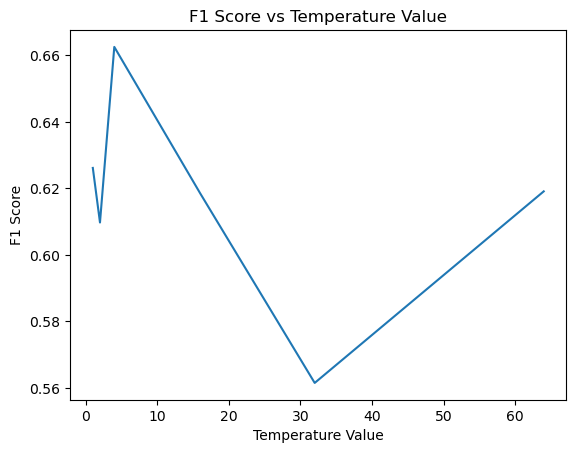

In [19]:
#plot the result vs Temperature
plt.plot(Ts,student_f1_results,label = "F1 Scores")
plt.xlabel("Temperature Value")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Temperature Value")
plt.show()

In [20]:
max_index = student_f1_results.index(max(student_f1_results))
T_max = Ts[max_index]
print("T value with maximum F1 Score is: {}".format(T_max))

T value with maximum F1 Score is: 4


Based on the graph and data, the F1 score reaches maximum when T = 4.

In [21]:
#Tune Alpha
#Based on the previous result, when T=4, the F1 Score and AUC score are max. Therefore, we will use T=4 to tune alpha

#Decrease the learning rate of transfer learning by 0.1
As = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
T = 4

In [22]:
student_models = []
#reset GPU Memory
reset_keras()
#Transfer Learning
for a in As:
    print("a = {}".format(a))
    student = student_model()
    student_models.append(student)
    distiller = Distiller(student = student, teacher = teacher)
    distiller.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
        distillation_loss_fn = keras.losses.KLDivergence(),
        alpha = a,
        temperature = T
    )
    distiller.fit(train_images_normalized, train_labels_encoded, epochs = FINE_TUNE_EPOCHS)
    reset_keras()
    

72052
a = 0.1
Epoch 1/25
204/204 [==============================] - 20s 82ms/step - sparse_categorical_accuracy: 0.7151 - student_loss: 0.8488 - distillation_loss: 0.0069
Epoch 2/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7663 - student_loss: 0.6364 - distillation_loss: 0.0055
Epoch 3/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7828 - student_loss: 0.5607 - distillation_loss: 0.0051
Epoch 4/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7977 - student_loss: 0.5132 - distillation_loss: 0.0047
Epoch 5/25
204/204 [==============================] - 17s 82ms/step - sparse_categorical_accuracy: 0.8028 - student_loss: 0.4882 - distillation_loss: 0.0045
Epoch 6/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7982 - student_loss: 0.5049 - distillation_loss: 0.0046
Epoch 7/25
204/204 [========================

In [23]:
student_f1_results = []
student_auc_results = []
reset_keras()
for model in student_models:
    y_pred = model.predict(test_images_normalized)
    y_pred = np.rint(y_pred)
    result = np.argmax(y_pred, axis=1)
    f1_score_result = metrics.f1_score(test_labels_encoded,result)
    student_f1_results.append(f1_score_result)
    reset_keras()

110
31/31 [==============================] - 1s 24ms/step
14542
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 23ms/step
756
31/31 [==============================] - 1s 23ms/step
756
31/31 [==============================] - 1s 23ms/step
756
31/31 [==============================] - 1s 24ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 23ms/step
756


In [24]:
print(student_f1_results)

[0.5790349417637272, 0.6035313001605137, 0.4767441860465116, 0.5848142164781907, 0.6559802712700371, 0.5936981757877281, 0.5921259842519685, 0.6573957016434894, 0.6160714285714285, 0.628808864265928]


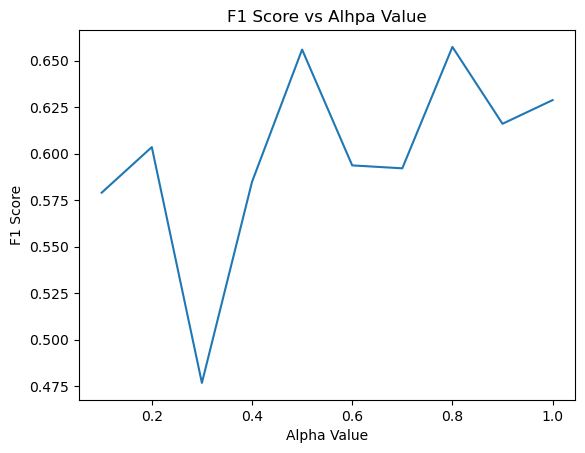

In [25]:
plt.plot(As,student_f1_results, label = "F1 Score")
plt.xlabel("Alpha Value")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Alhpa Value")
plt.show()

In [27]:
max_index = student_f1_results.index(max(student_f1_results))
Alpha_max = As[max_index]
print("Alpha Value with maximum F1 Score is: {}".format(Alpha_max))

Alpha Value with maximum F1 Score is: 0.8


## Train and Compare

In [58]:
# teacher model
teacher = teacher_model()

#student model
student = student_model()

In [59]:
#Train teacher model
teacher.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_TEACHER),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
#Train teacher model
reset_keras()
teacher.fit(train_images_normalized, train_labels_encoded, epochs= FINE_TUNE_EPOCHS)

1841
Epoch 1/25
204/204 [==============================] - 14s 57ms/step - loss: 0.5863 - sparse_categorical_accuracy: 0.7477
Epoch 2/25
204/204 [==============================] - 11s 56ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.8610
Epoch 3/25
204/204 [==============================] - 11s 56ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9379
Epoch 4/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9821
Epoch 5/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9974
Epoch 6/25
204/204 [==============================] - 12s 57ms/step - loss: 0.0182 - sparse_categorical_accuracy: 1.0000
Epoch 7/25
204/204 [==============================] - 12s 57ms/step - loss: 0.0100 - sparse_categorical_accuracy: 1.0000
Epoch 8/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0062 - sparse_categorical_accuracy: 1.0000
Epoch 9/25
204/204 [=======

In [60]:
#Predict on test images
reset_keras()
y_pred = teacher.predict(test_images_normalized)
y_pred = np.rint(y_pred)

800
31/31 [==============================] - 2s 54ms/step


In [61]:
result = np.argmax(y_pred,axis= 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Teacher Model Initial f1 score: {}".format(f1_score_result))

Teacher Model Initial f1 score: 0.7410586552217453


In [62]:
distiller = Distiller(student=student, teacher=teacher)
#From the previous fine tuning result, the alpha = 0.8 and T = 4
distiller.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn = keras.losses.KLDivergence(),
    alpha = 0.8,
    temperature = 4
)
#Train student model with knpwledge distillation
reset_keras()
distiller.fit(train_images_normalized,train_labels_encoded,epochs =  FINE_TUNE_EPOCHS)


756
Epoch 1/25
204/204 [==============================] - 20s 82ms/step - sparse_categorical_accuracy: 0.6995 - student_loss: 0.9223 - distillation_loss: 0.0073
Epoch 2/25
204/204 [==============================] - 17s 82ms/step - sparse_categorical_accuracy: 0.7548 - student_loss: 0.6590 - distillation_loss: 0.0058
Epoch 3/25
204/204 [==============================] - 17s 82ms/step - sparse_categorical_accuracy: 0.7762 - student_loss: 0.6286 - distillation_loss: 0.0054
Epoch 4/25
204/204 [==============================] - 17s 82ms/step - sparse_categorical_accuracy: 0.7954 - student_loss: 0.4989 - distillation_loss: 0.0046
Epoch 5/25
204/204 [==============================] - 17s 84ms/step - sparse_categorical_accuracy: 0.8097 - student_loss: 0.4563 - distillation_loss: 0.0043
Epoch 6/25
204/204 [==============================] - 17s 84ms/step - sparse_categorical_accuracy: 0.8051 - student_loss: 0.4818 - distillation_loss: 0.0045
Epoch 7/25
204/204 [==============================] - 

In [63]:
reset_keras()
y_pred = student.predict(test_images_normalized)
y_pred = np.rint(y_pred)

800
31/31 [==============================] - 1s 24ms/step


In [64]:
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Student Model with Knowledge Distillation f1 score: {}".format(f1_score_result))

Student Model with Knowledge Distillation f1 score: 0.624420401854714


In [74]:
#Build Student from scratch
student_scratch = student_model()

student_scratch.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_SC),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
reset_keras()
student_scratch.fit(train_images_normalized, train_labels_encoded, epochs =  FINE_TUNE_EPOCHS)

1943
Epoch 1/25
204/204 [==============================] - 8s 30ms/step - loss: 0.8490 - sparse_categorical_accuracy: 0.7145
Epoch 2/25
204/204 [==============================] - 6s 30ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.7522
Epoch 3/25
204/204 [==============================] - 6s 30ms/step - loss: 0.5674 - sparse_categorical_accuracy: 0.7819
Epoch 4/25
204/204 [==============================] - 6s 30ms/step - loss: 0.6125 - sparse_categorical_accuracy: 0.7720
Epoch 5/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4642 - sparse_categorical_accuracy: 0.8070
Epoch 6/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4533 - sparse_categorical_accuracy: 0.8072
Epoch 7/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4623 - sparse_categorical_accuracy: 0.8070
Epoch 8/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4120 - sparse_categorical_accuracy: 0.8250
Epoch 9/25
204/204 [===============

In [75]:
#Pred on the test images
reset_keras()
y_pred = student_scratch.predict(test_images_normalized)
y_pred = np.rint(y_pred)

800
31/31 [==============================] - 1s 29ms/step


In [76]:
result = np.argmax(y_pred, axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Student Model from Scratch F1 Score: {}".format(f1_score_result))

Student Model from Scratch F1 Score: 0.5226860254083485
